# SLT-CE-6: Mean Field Approximation

<p style="background-color:#adebad;">
In this coding exercise we will implement a Meand Field Approximation approach and evaluate its performance on two problems:  
    <br> 1) The 2D Ising model (aka image reconstruction model) already seen in Coding Exercise 1 and  </li>
<br> 2) A Wine Dataset <b>different from the one in Coding Exercise 2</b>. 
</p>

# References 

[1] [Lecture slides](https://ml2.inf.ethz.ch/courses/slt/lectures/mean-field-slides.pdf)

[2] [Exercises](https://ml2.inf.ethz.ch/courses/slt/exercises/exercise8.pdf)

[3] [Tutorial notes](https://ml2.inf.ethz.ch/courses/slt/tutorials/SLT%20Tutorial%208.pdf)

[4] [Wine data set](http://archive.ics.uci.edu/ml/datasets/Wine)

[5] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

[6] [An Introduction to Variational Methods for Graphical Models](https://people.eecs.berkeley.edu/~jordan/papers/variational-intro.pdf)


# Image denoising using mean field approximation

## Task

<p style="background-color:#adebad;">In the first part of the coding exercise (Sections 4.0-5.0) we will use the mean field
approximation to solve the 2D Ising model (aka image riconstruction model). 
We have already encountered this 2D Ising model in Coding Exercise 1 (see also the tutorial [3] and exercise [2] -  the model originates from Section 8.3.3 of [5]). 
<br><br>
Your task is to apply/implement the mean field approximation and then compare it to the MCMC (for which we provide you an implementation below).
</p>

## Setup

We start by importing necessary python packages.

In [1]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import time
import sklearn
from SMK import SmoothKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.manifold import MDS
from utils import compute_cluster_mapping, compute_bic


We load the original image of size 300x300 which we will be trying to reconstruct. White pixels have values -1 and the black pixels are of value +1.

In [2]:
IMG_ORIGINAL = mpimg.imread("flower.png")#[:,:,0]/255
IMG_ORIGINAL[IMG_ORIGINAL > 0.5] = 1
IMG_ORIGINAL[IMG_ORIGINAL <= 0.5] = -1

Check the dimensions of the image

In [3]:
IMG_HEIGHT = IMG_ORIGINAL.shape[0]
IMG_WIDTH = IMG_ORIGINAL.shape[1]
IMG_ORIGINAL.shape

(300, 300)

Plot the original image

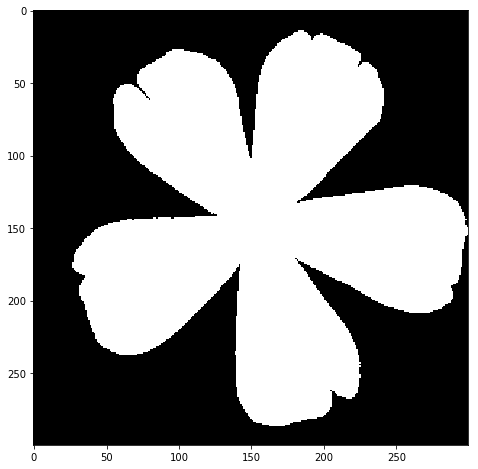

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_ORIGINAL, cmap='gray')
plt.show()

Generate the noisy version - flip random 30% of pixels. 

In [5]:
# Fix random seed for reproducibility
np.random.seed(13)

IMG_NOISY_OBSERVATION = IMG_ORIGINAL.copy()
num_flips = int(0.3 * IMG_HEIGHT * IMG_WIDTH)

perm = np.random.permutation(IMG_ORIGINAL.size)[0:int(0.3 * IMG_ORIGINAL.size)]
for k in perm:
    i = int(k/IMG_WIDTH)
    j = k%IMG_HEIGHT
    IMG_NOISY_OBSERVATION[i,j] = -IMG_NOISY_OBSERVATION[i,j]

Plot the noisy version of the original image

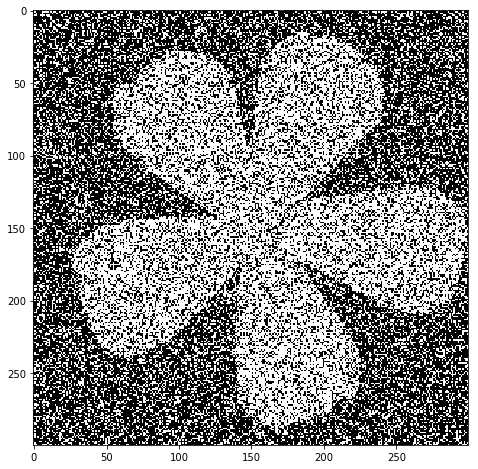

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_NOISY_OBSERVATION, cmap='gray')
plt.show()

We will fix the parameters of the model as


In [7]:
H = 0.0
Beta = 1.0
Eta = 2.1

Global computation of the energy

In [8]:
def energy(img_estimate, img_noisy_observation):
    """Compute the energy for given estimate 'img_estimate'
    with respect to the  observation 'img_noisy_observation'.

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
            energy (float): energy of the estimate given observation
    """
    kernel = np.asarray([[1,1,1],[1,0,1],[1,1,1]])
    neigh_sum = convolve(img_estimate, kernel, mode="constant", cval=0)
    return - np.sum(H * img_estimate + \
                    Eta * img_estimate * img_noisy_observation + \
                    Beta * img_estimate * neigh_sum)

In [9]:
energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION)

-300855.94

Estimating loss via mean squared error

In [10]:
def mse_loss(img_estimate, img_original):
    """Computing mean squared error loss

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_original (np.ndarray): original image matrix

    Returns:
            mse (float): mean squared error between two matrices
    """
    err = np.sum((img_estimate.astype("float") - img_original.astype("float")) ** 2)
    err /= float(img_estimate.shape[0] * img_estimate.shape[1])
    return err

Auxiliary function for the local energy computation of the implemented MCMC method.

In [11]:
def pixel_energy(img_estimate, img_noisy_observation, i, j):
    """Compute the energy localized around a pixel (i,j)

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix
            i,j (double, double): pixel coordinates

    Returns:
            energy (float): local energy around given pixel
    """
    return - ( H*img_estimate[i,j]+\
               Beta*img_estimate[i,j]*np.sum(img_estimate[i-1:i+2,j-1:j+2])+\
               Eta*img_estimate[i,j]*img_noisy_observation[i,j])

Display various energies and losses for the noisy image as our initial estimate with respect to the original image.

In [12]:
print(mse_loss(IMG_NOISY_OBSERVATION, IMG_ORIGINAL))
print(energy(IMG_ORIGINAL, IMG_NOISY_OBSERVATION))
print(energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION))

1.2
-773448.0
-300855.94


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
Briefly recap the theory of the mean field approximation. 
    <br> (You can choose to describe only one of the many derivation given in the tutorial [3], e.g., variational upper bound.)  
</p>


The main idea behind the mean field approximation $\mathcal{Q}$ is to assume that it is of a factorial form and then minimize the Kullback-Leibler divergence between $\mathcal{P}$ and $\mathcal{Q}$ to obtain the best factorial approximation $\mathcal{Q}$ of $\mathcal{P}$.

The Gibbs distribution for a general cost function $\mathcal{R}(c)$ can be written as:
$$\mathcal{P}(c) = exp{(-\beta(\mathcal{R}(c) - \mathcal{F} )}$$


where $\mathcal{F}$ is the free energy.

Let $\mathcal{Q}$ be a factorial approximation to $\mathcal{P}$ given by:

$$ \mathcal{Q}(c) = \prod_{i \leq n} q_i(c(i))$$

Then, it is easy to derive the following upper bound for the free energy $\mathcal{F}$:

$$\mathcal{F} \leq \dfrac{1}{\beta} \sum_{s\leq n} \sum_{\nu\leq k} q_s(\nu) \log{q_s(\nu)} + \mathbb{E}_{c \sim \mathcal{ Q}}[\mathcal{R}(c)] \equiv \mathcal{B}(\mathcal{Q})  $$

The bound $\mathcal{B}$ is the free energy of $\mathcal{Q}$ and it has to be minimized with respect to the $\{q_i(\nu)\}$ subject only to the normalization constraints.

<p style="background-color:#adebad;">
With the help of [2,3], explain the algorithm for solving image denoising using mean field approximation.
    <br>
    (Please try to be consistent in notation/symbols used here and in the previous question - same quantities should be denoted with the same symbol.)
</p>

Recall the cost function $\mathcal{R}$ from the Ising Model:
$$\mathcal{R}(c) = - \lambda \sum_{i=1}^N h_i c_i - \sum_{i,j =1}^{N} J_{i,j} c_i c_j$$

where:
- N is the number of pixels in the image
- $\{h_i\}_{i=1}^N$ is the noisy image
- $\{c_i\}_{i=1}^N$ is the denoised image
- $\lambda \geq 0$
- $ \forall (i,j) \; \; J_{i,j} \geq 0 $

We define an approximate cost function $\mathcal{R}_0$ of the form:

$$\mathcal{R}_0 = - \sum_i c_i h_i^{eff}$$

and let $\mathcal{Q}$ be the corresponding Gibbs distribution. Then, $p_0$ can be factorized as:

$$\mathcal{Q}(c) = \prod_{i=1}^N q_i(c_i) = \prod_{i=1}^N \dfrac{1+c_i m_i}{2}$$

where $m_i = \mathbb{E}_{c_i \sim q_i}[c_i]$.

Finally, we derive that $m_k$ for minimized $\mathcal{B}(\mathcal{Q})$ are given by:

$$ m_k = tanh[\beta(\sum_{i \neq k } J_{k, i} m_i + \lambda h_k)] \; \; k=1,\ldots, N $$

This set of $N$ equations can be solved iteratively by cycling through the variables.

<p style="background-color:#adebad;">
Implement mean field algorithm for image denoising. You are provided with an implementation of the metropolis algorithm as a representative of MCMC, for the sake of comparison. Note that the 'epochs' parameter below is introduced solely to ease the plotting procedure and it is up to you assign the semantics to it.
    Evaluate your mean field implementation using 'evaluate' function, and compare your results to MCMC. Explain clearly the differences between them.
    <br>1) Does your implementation converge faster? 
    <br>2) What are the disadvantages and advantages?
<br><br>
Consider running the comparison on another image to prove your point.
Also, feel free to replace our implementation of MCMC with your own.
</p>

In [13]:
def metropolis(img_noisy_observation, img_original, epochs):
    """Do the metropolis sampling starting from the noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
   
    img_estimate = img_noisy_observation.copy()
    img_estimate_padded = np.pad(img_estimate, 1, mode='constant', constant_values=0)
    img_noisy_observation_padded = np.pad(img_noisy_observation, 1, mode='constant', constant_values=0)

    T = 1.0

    energy_vals = []
    loss = []

    for e in range(epochs):
        for i in range(1,img_original.shape[0]+1):
            for j in range(1,img_original.shape[1]+1):
                # calculate local energy
                pixel_cur_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # flip the pixel
                img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                # calculate new local energy
                pixel_new_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # energy difference
                dE = pixel_new_energy - pixel_cur_energy
                # do metropolis thingy
                if dE > 0:
                    p = 0.5*(1-np.tanh(0.5 / T * dE))
                    rr = np.random.rand(1)
                    if rr > p:
                        # revert back pixel
                        img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                    # append energy
                if j % 200 == 0:
                    energy_vals.append(energy(img_estimate_padded[1:-1,1:-1],img_noisy_observation))
                    loss.append(mse_loss(img_estimate_padded[1:-1,1:-1],img_original))

    return img_estimate_padded[1:-1,1:-1], np.asarray(energy_vals), np.asarray(loss)

In [14]:
def meanfield(img_noisy_observation, img_original, epochs, **kwargs):
    """Do the meanfield approximation to estimate the reconstruction.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    
    energies = []
    losses = []    
    neighbors_kernel = kwargs['kernel']
    T = kwargs['T']
    # artifically construct energies and losses arrays
    img_estimate = img_noisy_observation.copy() # initialize to the noisy img
    for i in range(epochs):
        img_estimate_old = img_estimate.copy()
        J = Beta * convolve(img_estimate, neighbors_kernel)
        H = Eta * img_noisy_observation
        img_estimate = np.tanh(1/T * (J + H))
        E = energy(img_estimate, img_noisy_observation)
        L = mse_loss(img_estimate, img_original)
        energies.append(E)
        losses.append(L)
    return img_estimate, np.asarray(energies), np.asarray(losses)

In [15]:
def evaluate(method, img_noisy_observation, img_original, epochs=1, **kwargs):
    """ Given an inference method, we will run the estimation procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
            method (function pointer): sampling method
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
            epochs (int): number of epochs to run the sampling
    """
    # Run specified sampling method
    start_time = time.time()
    img_estimate, energies, losses = method(img_noisy_observation, img_original, epochs, **kwargs)
    execution_time = time.time() - start_time
    # Plot energy and MSE drop
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.plot(energies)
    ax1.set_title('Energy Drop')
    ax2.plot(losses)
    ax2.set_title('MSE Loss Drop')
    ax3.imshow(img_estimate, cmap='gray')
    ax3.set_title('Reconstruction')
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    plt.suptitle("Executed in approx. "+str(int(execution_time)) + " seconds")
    # show plots
    plt.show()


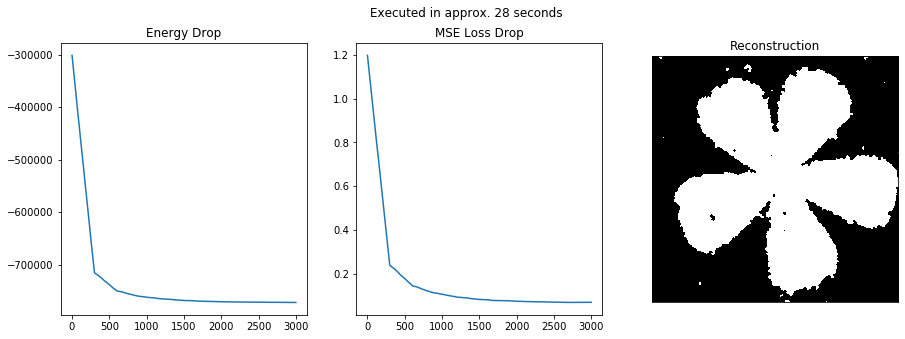

CPU times: user 57.1 s, sys: 543 ms, total: 57.7 s
Wall time: 29 s


In [16]:
%%time
evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 10)

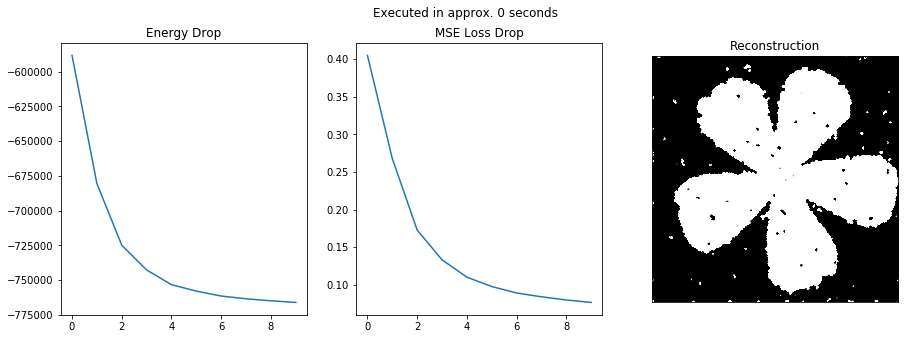

CPU times: user 1.28 s, sys: 304 ms, total: 1.59 s
Wall time: 242 ms


In [19]:
%%time 
img = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 10, 
         T=1, 
         kernel= np.array([[1,1,1], [1,0,1], [1,1,1]])
        )

<p style="background-color:#adebad;">
Compare and analyze performance
</p>

### Does your implementation converge faster? 

The mean field approximation does indeed converge faster (30s vs 300ms) by a factor of 100.  

###  What are the disadvantages and advantages? 
- The main advantage is the time efficiency of the mean field algorithm.
- The main disadvantage is that we converge towards a worse solution in the sense of MSE error since we are not sampling from the original gibbs distribution.


<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>


<p style="background-color:#adebad;">
Comment on the convergence of the method by answering these two questions.
    <br>1) How can we tell if the mean field convereged? 
    <br>2) Do we always reach the global optimum?
</p>

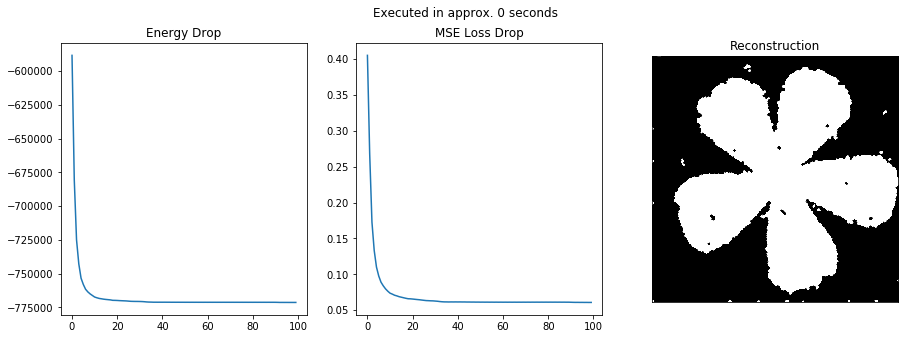

In [20]:
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 100, 
          T=1, 
         kernel= np.array([[1,1,1], [1,0,1], [1,1,1]])
        )

### How can we tell if the mean field converged?

We can check the `Energy Drop` plot above to tell if the mean field converged; in particular when the energy stops decreasing the algorithm has reached a stationary point. 

### Do we always reach the global optimum?

We don't always reach the global optimum. Even though the free energy upper bound $\mathcal{B}$ is convex and each EM-step strictly improves the solution we have no guarantees on the quality of the optima with respect to the original energy function.

<h2 style="background-color:#f0b375;">
Section 5.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
How do the parameters of the Ising model, and the temperature affect the performance of the mean field?
Plot image reconstructions for different settings of the model parameters (at least 10 experiments). Also, plot the reconstruction with varying parameters of the mean field algorithm. 
    <br>1) Can you explain the behaviour? 
    <br>2) Do you see a difference in the reconstraction at different temperature?
</p>

### Reconstruction at different temperatures 

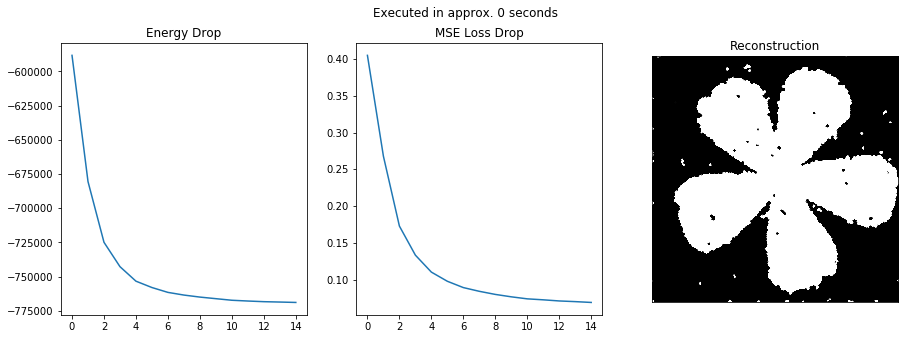

In [21]:
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 15, 
          T=1, 
         kernel= np.array([[1,1,1], [1,0,1], [1,1,1]])
        )

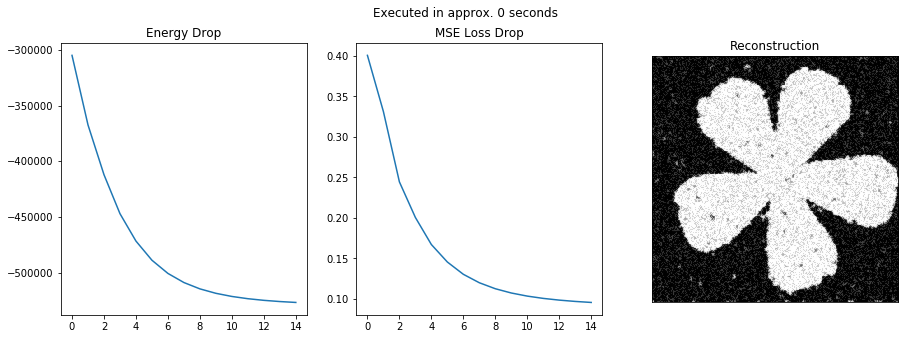

In [22]:
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 15, 
          T=6, 
         kernel= np.array([[1,1,1], [1,0,1], [1,1,1]])
        )

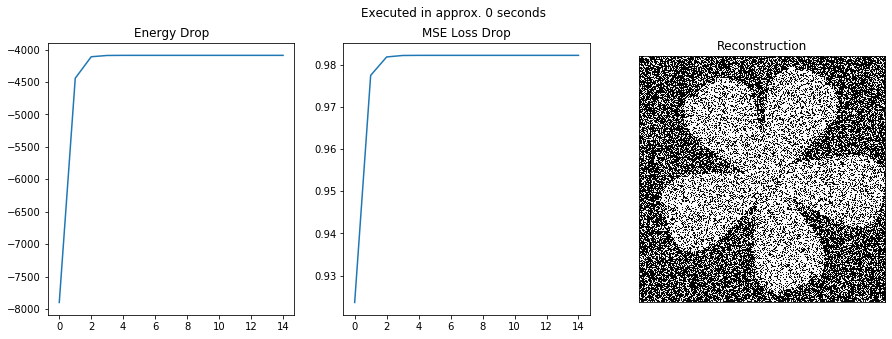

In [23]:
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 15, 
          T=100, 
         kernel= np.array([[1,1,1], [1,0,1], [1,1,1]])
        )

We plot the mean field reconstruction at different temperatures. It is clear from the experiments that as we increase the temperature parameter, the Gibbs Distribution induced by the energy function becomes too flat and we are not able to reconstruct the image anymore. 

### Reconstruction at different Etas

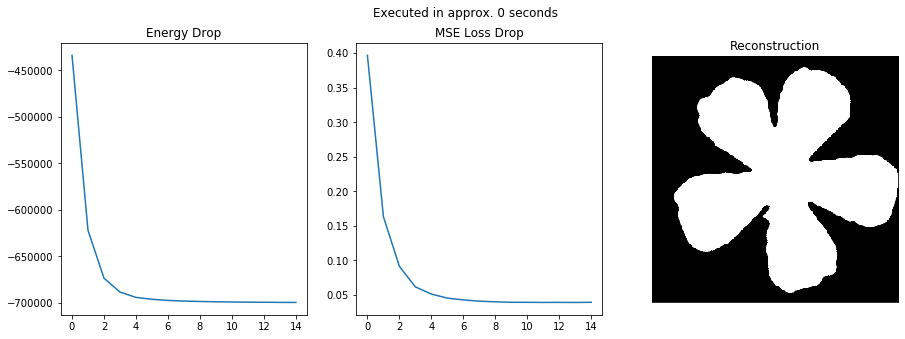

In [24]:
Eta = 1e-2
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 15, 
          T=1, 
         kernel= np.array([[1,1,1], [1,0,1], [1,1,1]])
        )

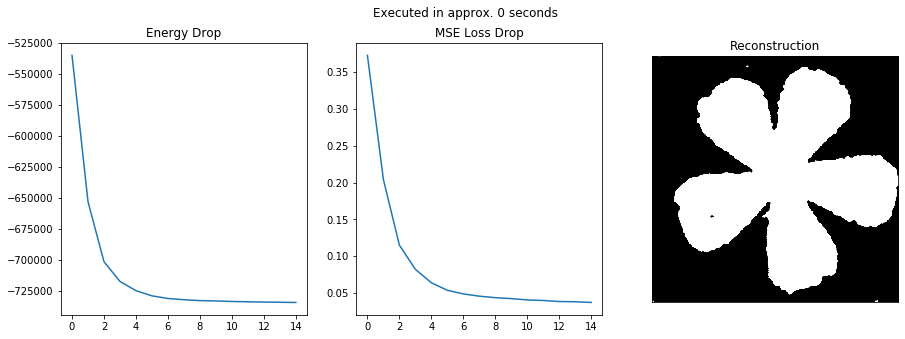

In [25]:
Eta = 1
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 15, 
          T=1, 
         kernel= np.array([[1,1,1], [1,0,1], [1,1,1]])
        )

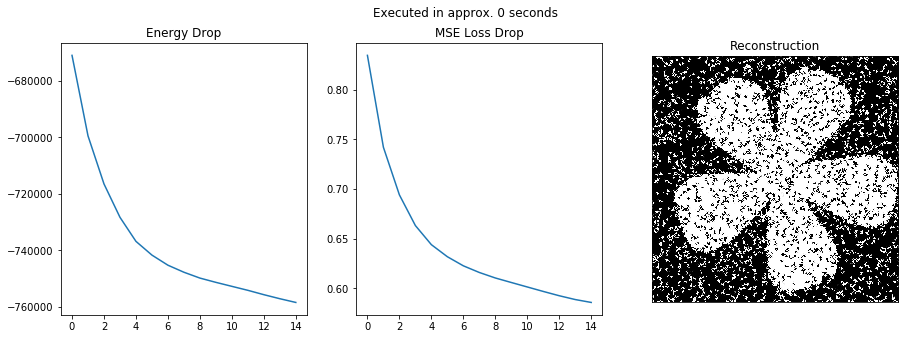

In [26]:
Eta = 5
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 15, 
         T=1, 
         kernel= np.array([[1,1,1], [1,0,1], [1,1,1]])
        )

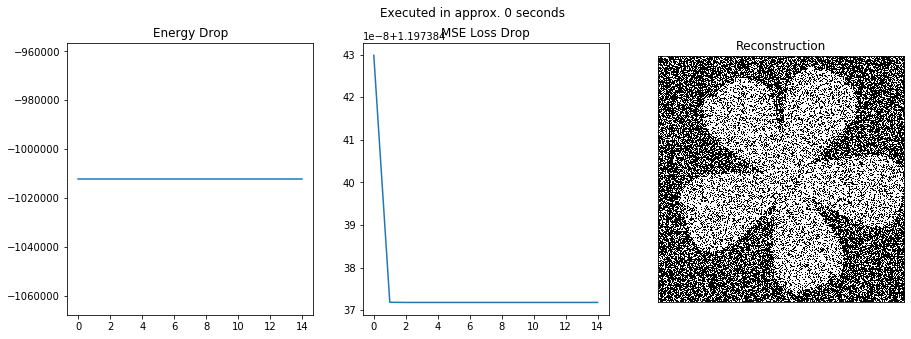

In [29]:
Eta = 10
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 15, 
          T=1, 
         kernel= np.array([[1,1,1], [1,0,1], [1,1,1]])
        )

We plot the mean field reconstruction at different values of the $\eta$ parameter. We can infer from the experiments above that the optimal value for the parameter is the smallest one, i.e. $10^{-2}$. Furthermore, the image reconstruction quality decreases as we increase $\eta$; this is due to the fact that the cost of disagreeing with the noisy image becomes larger and larger.

### Reconstruction with different neighborhood topologies

In [30]:
H = 0.0
Beta = 1.0
Eta = 2.1

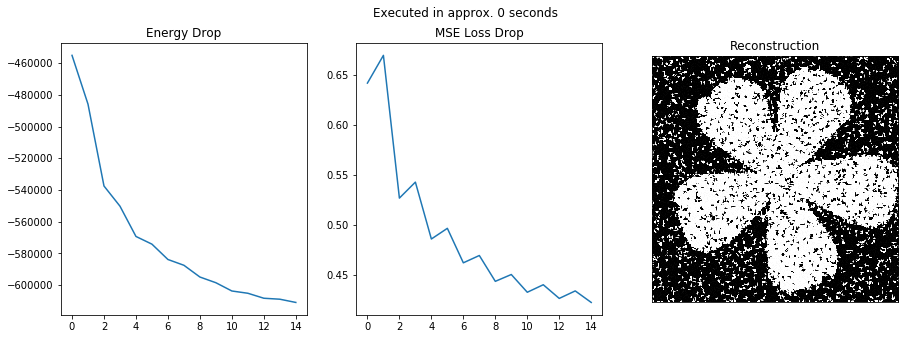

In [31]:
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 15, 
          T=1, 
         kernel= np.array([[0,1,0], [1,0,1], [0,1,0]])
        )

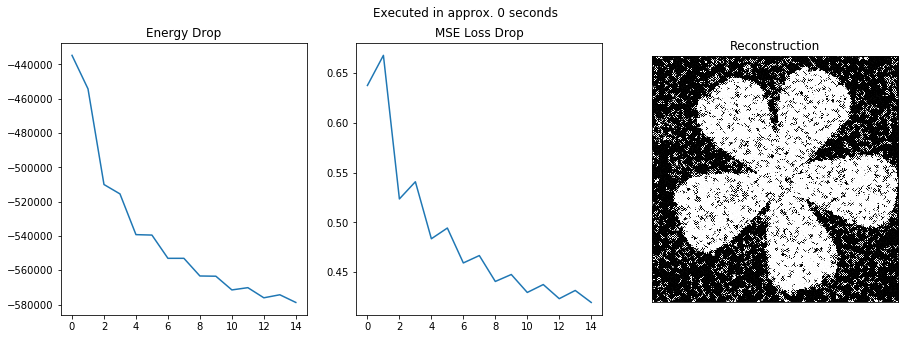

In [32]:
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 15, 
          T=1, 
         kernel= np.array([[1,0,1], [0,0,0], [1,0,1]])
        )

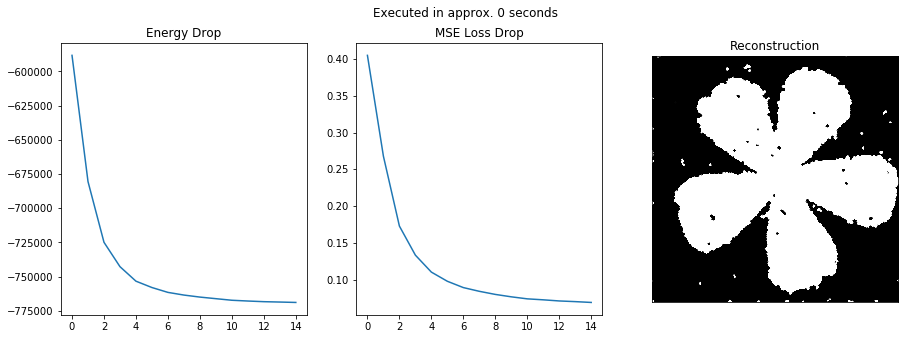

In [33]:
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 15, 
          T=1, 
         kernel= np.array([[1,1,1], [1,0,1], [1,1,1]])
        )

We plot the mean field reconstruction at different values of the kernel parameter. We notice that considering a larger neighborhood of pixels significantly improves the reconstruction and reduces the noise. This experiment, together with the one testing the $\eta$ parameter, suggests that in order to achieve a perfect reconstruction it is important to find a good balance between the influence of neighboring pixel (kernel matrix) and the influence of the original noisy pixel ($\eta$).

### Reconstruction with different Beta

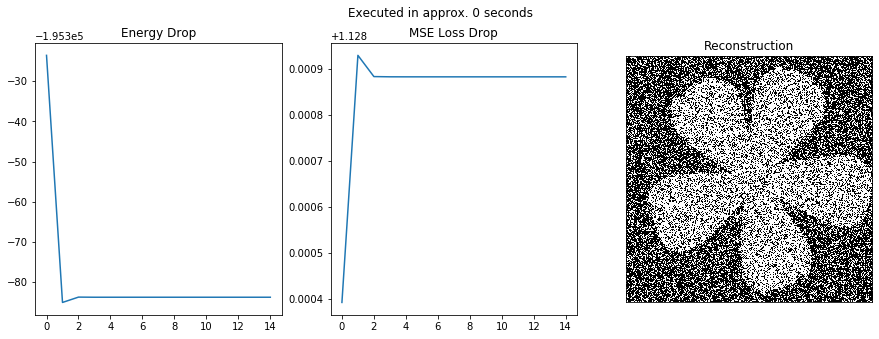

In [34]:
Beta = 1e-1
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 15, 
          T=1, 
         kernel= np.array([[1,1,1], [1,0,1], [1,1,1]])
        )

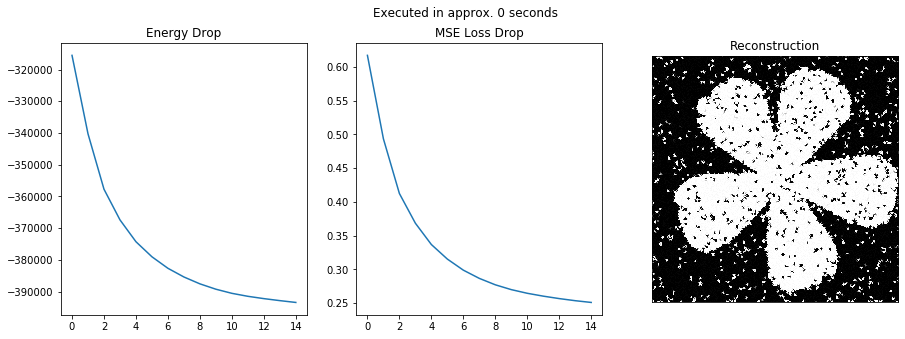

In [35]:
Beta = 5e-1
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 15, 
          T=1, 
         kernel= np.array([[1,1,1], [1,0,1], [1,1,1]])
        )

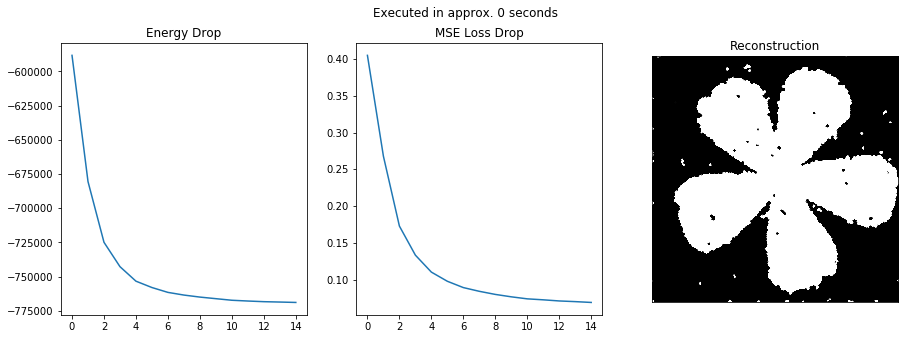

In [36]:
Beta = 1
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 15, 
          T=1, 
         kernel= np.array([[1,1,1], [1,0,1], [1,1,1]])
        )

We plot the mean field reconstruction at different values of the $\beta$ parameter.
We notice that increasing the influence of the pixel neighborhood significantly improves the reconstruction and reduces the noise. 

<h2 style="background-color:#f0b375;">
Section 5.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    For this and for all the following tasks, you have to use a different dataset: the <b>Wine data set</b> in [4] (this is <b>not</b> the Wine Dataset in previous coding exercise - please download the one in [4]). This data set contains three classes, see more detailed description online. 
    <br><br>
    Implement both (1) plain-vanilla k-means and (2) smooth k-means in mean field [1], and compare them on the Wine data set.
#</p>

In [37]:
# Load the dataset 
wine = pd.read_csv("wine.data")
X = wine.drop(columns=["1"]).values
y = wine["1"].values -1

In [38]:
# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [39]:
# Vanilla KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans_pred = kmeans.predict(X)

In [40]:
# Smooth KMeans threshold 3 => 20 neighbors in average
smoothkmeans = SmoothKMeans(lambda_param=5e-1, threshold=3.02, n_clusters=3,T=1e-1)
smoothkmeans.fit(X)
smooth_pred = smoothkmeans.predict()

In [41]:
# Compute mapping of cluster assignment wrt ground truth
cmap_kmeans = compute_cluster_mapping(kmeans_pred,y, n_clusters=3)
cmap_smooth = compute_cluster_mapping(smooth_pred,y, n_clusters=3)
kmeans_pred = np.asarray([cmap_kmeans[int(i)] for i in kmeans_pred])
smooth_pred = np.asarray([cmap_smooth[int(i)] for i in smooth_pred])

In [42]:
print("Accuracy KMeans: " + str(accuracy_score(kmeans_pred, y)))
print("Accuracy Smooth KMeans: " + str(accuracy_score(smooth_pred,y)))

Accuracy KMeans: 0.9661016949152542
Accuracy Smooth KMeans: 0.9717514124293786


<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Visualize the clustering by embedding the data to 2D and indicate the labeling by k-means compared
to the ground truth.
</p>

In [43]:
mds = MDS()
X_embed = mds.fit_transform(X)

Text(0.5, 1.0, '2D Embedding Smooth KMeans')

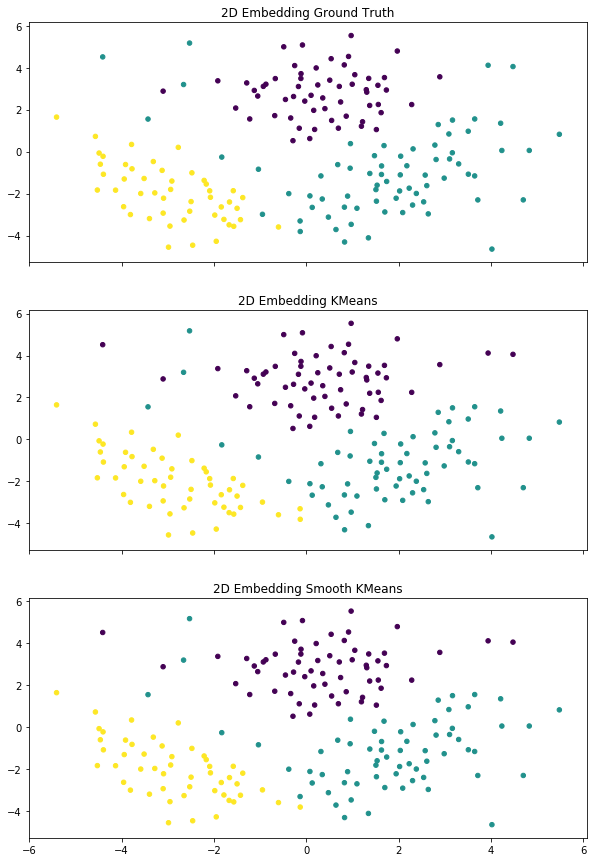

In [44]:
fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(10)
axs[0].scatter(X_embed[:,0], X_embed[:,1], c=y, s=20)
axs[0].set_title("2D Embedding Ground Truth")
axs[1].scatter(X_embed[:,0], X_embed[:,1], c=kmeans_pred, s=20)
axs[1].set_title("2D Embedding KMeans")
scatter = axs[2].scatter(X_embed[:,0], X_embed[:,1], c=smooth_pred, s=20)
axs[2].set_title("2D Embedding Smooth KMeans")

<p style="background-color:#adebad;">
Use the available labels (1-3) to assess the cluster purity and comment on the observed vs. the expected
effect of smooth k-means.
</p>

In [45]:
def purity(cm):
    return np.sum(np.max(cm,axis=0))/np.sum(cm)

In [46]:
from sklearn.metrics import confusion_matrix

kmeans_cm = confusion_matrix(kmeans_pred, y)
smooth_cm = confusion_matrix(smooth_pred, y)
print("Purity KMeans: " + str(purity(kmeans_cm)))
print("Purity Smooth KMeans: " + str(purity(smooth_cm)))

Purity KMeans: 0.9661016949152542
Purity Smooth KMeans: 0.9717514124293786


We compute the purity for KMeans and Smooth KMeans. We observe that the "smoothed" solution has a slightly better purity and this is expected since Smooth KMeans should perform incrementally better than KMeans.

<p style="background-color:#adebad;">
Evaluate the BIC score for both algorithms (make use of the meanfield-approximation for smooth
k-means). 
    <br>1) Does it indicate 3 clusters? 
    <br>2) How does the smooth k-means clustering solution change when varying the temperature of the mean field approximation?
</p>

In [47]:
%%time
bic_kmeans = []
bic_smooth = []
ks = [ i for i in range(2,10)]
for k in ks:
    smooth = SmoothKMeans(T=1e-1,n_clusters=k, lambda_param=5e-1, threshold=3)
    smooth.fit(X)
    bic_smooth.append(compute_bic([smooth.cluster_centers],smooth.predict(),X,k))
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    bic_kmeans.append(compute_bic([kmeans.cluster_centers_],kmeans.predict(X),X,k))

CPU times: user 7.18 s, sys: 19.4 ms, total: 7.2 s
Wall time: 7.19 s


Text(0.5, 0, 'n_cluster')

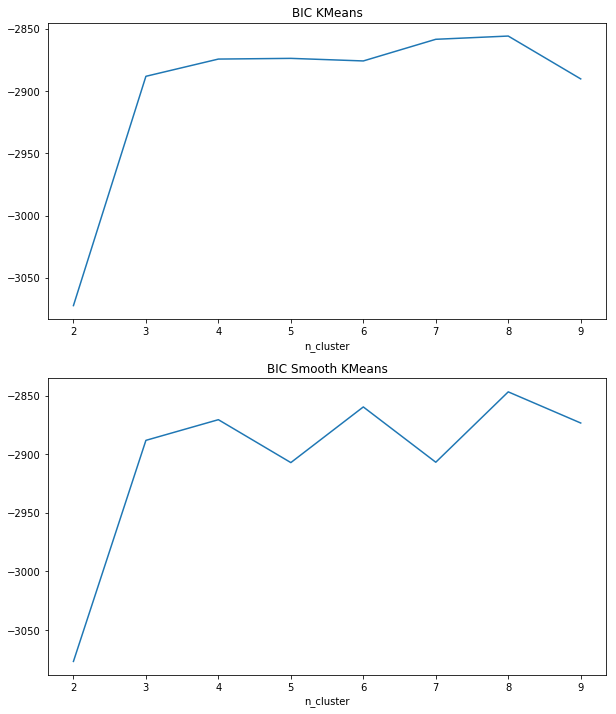

In [48]:
fig, axs = plt.subplots(2)
fig.set_figheight(12)
fig.set_figwidth(10)
axs[0].plot(ks, bic_kmeans)
axs[0].set_title("BIC KMeans")
axs[1].plot(ks, bic_smooth)
axs[1].set_title("BIC Smooth KMeans")
axs[0].set_xlim()
axs[0].set_xlabel("n_cluster")
axs[1].set_xlabel("n_cluster")

The elbow of the curve is found at $k=4$ for both KMeans and Smooth KMeans, nevertheless $k=3$ would be a reasonable choice. 

On the other hand, if we consider the absolute maximum of the curve, BIC score advocates for $k=8$ which is way off the actual number of clusters in the wine dataset.

### Clustering solution at different temperatures

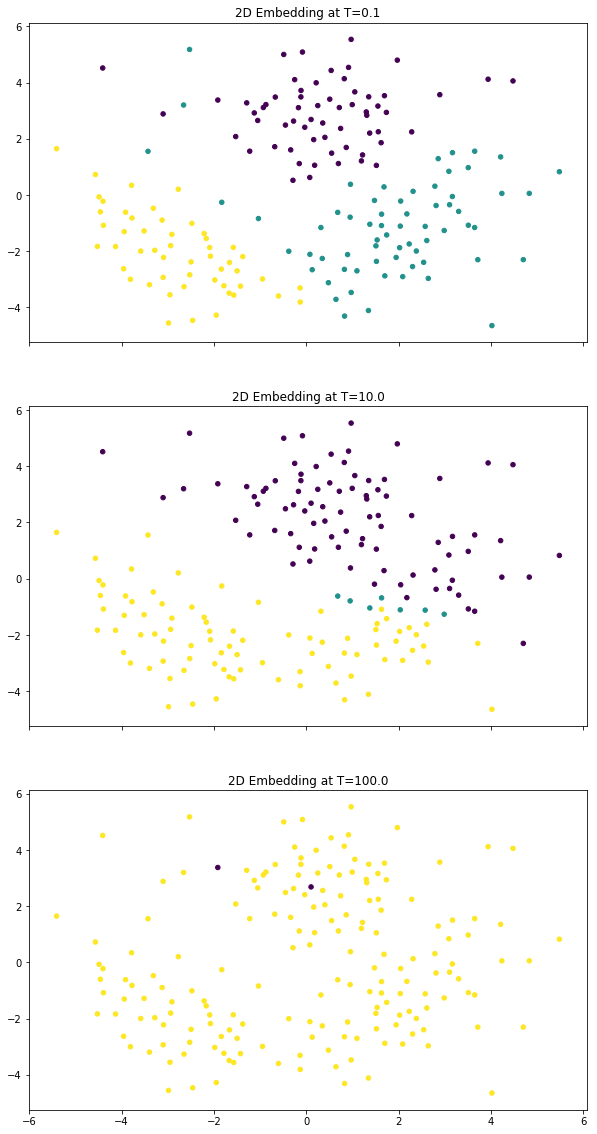

In [49]:
ts = np.asarray([1e-1, 10, 100])
fig, axs = plt.subplots(ts.size, sharex=True, sharey=True)
fig.set_figheight(20)
fig.set_figwidth(10)

for t,i in zip(ts,range(ts.size)):
    smoothkmeans = SmoothKMeans(lambda_param=1e-1,threshold=3.02, T=t)
    smoothkmeans.fit(X)
    y_pred = smoothkmeans.predict()
    cmap = compute_cluster_mapping(y_pred,y, n_clusters=3)
    y_pred = np.asarray([cmap[int(i)] for i in y_pred])  
    axs[i].scatter(X_embed[:,0], X_embed[:,1], c=y_pred, s=20)
    axs[i].set_title("2D Embedding at T=" + str(t))



We plot the 2-dimensional embedding colored with smooth-kmeans labels. As expected, when the temperature $T$ is very high we have one big cluster. As $T$ gradually decreases the "resolution" of the clustering gets better and better. Once we reach $T=0.1$ three clusters emerge clearly from the plot.

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.